<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (9 баллов)

## 1.1. Подготовка данных (0.5 балла)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd

import os
import skimage.io
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
def fetch_dataset(
        attrs_name = "lfw_attributes.txt",
        images_name = "lfw-deepfunneled",
        dx=80, dy=80,
        dimx=64, dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])

    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))
    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))


    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [3]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind

data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [4]:
data_train, data_val = train_test_split(data, train_size=0.8)
data_train.shape, data_val.shape

((10514, 64, 64, 3), (2629, 64, 64, 3))

In [5]:
np.moveaxis(data_train, -1, 1).shape

(10514, 3, 64, 64)

In [6]:
batch_size = 32
train_dataloader = DataLoader(
    np.moveaxis(data_train, -1, 1).astype(np.float32),
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

val_dataloader = DataLoader(
    np.moveaxis(data_val, -1, 1).astype(np.float32),
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
)

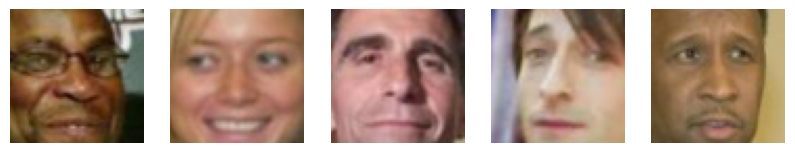

In [7]:
num_images = 5
plt.figure(figsize=(2 * num_images, 2))
for image_id in range(num_images):
    rand_img_id = np.random.randint(0, len(data_train))
    img = data_train[rand_img_id]
    plt.subplot(1, num_images, image_id+1)
    plt.axis("off")
    plt.imshow(img)

plt.show()

## 1.2. Архитектура модели (1.5 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, in_channels, latent_size=8):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # (_, 64, 64, 64) -> (_, 64, 32, 32)
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # (_, 128, 32, 32) -> (_, 128, 16, 16)
            nn.MaxPool2d(kernel_size=2, stride=2),

            # (_, 128, 16, 16)(_, 128 * 16 * 16)
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, latent_size),
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 128 * 16 * 16),
            # (_, 128 * 16 * 16) -> (_, 128, 16, 16)
            nn.Unflatten(1, (128, 16, 16)),
            # (_, 128, 16, 16) -> (_, 64, 32, 32)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # (_, 64, 32, 32) -> (_, 32, 64, 64)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, in_channels, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        latent_code = self.encode(x)
        reconstruction = self.decode(latent_code)
        return reconstruction, latent_code

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
epochs = 60
latent_size = 64

criterion = nn.MSELoss()
autoencoder = Autoencoder(in_channels=3, latent_size=latent_size).to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=3e-4)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [11]:
def train(model, epochs, critetion, optimizer, dataloader, device, verbose=1):
    model.train()
    loss_history = []
    for epoch in range(epochs):
        running_loss = 0
        total_data = 0

        for X_batch in dataloader:
            X_batch = X_batch.to(device)
            optimizer.zero_grad()

            reconstruction, _ = model(X_batch)
            loss = criterion(reconstruction, X_batch)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * X_batch.size(0)
            total_data += X_batch.size(0)

        loss = running_loss / total_data
        loss_history.append(loss)

        if verbose > 0 and (epoch + 1) % verbose == 0:
            print(f"Epoch: {epoch+1}/{epochs}, loss: {loss}")

    return loss_history

In [12]:
loss_history = train(autoencoder, epochs, criterion, optimizer, train_dataloader, device)

Epoch: 1/60, loss: 0.014671955923593235
Epoch: 2/60, loss: 0.009282278749310167
Epoch: 3/60, loss: 0.008331524400582258
Epoch: 4/60, loss: 0.007845791053386193
Epoch: 5/60, loss: 0.00757704262604162
Epoch: 6/60, loss: 0.007363340248092824
Epoch: 7/60, loss: 0.007212072509520403
Epoch: 8/60, loss: 0.0070607877883508115
Epoch: 9/60, loss: 0.006905551551064713
Epoch: 10/60, loss: 0.006873996904772147
Epoch: 11/60, loss: 0.006784433475150788
Epoch: 12/60, loss: 0.006681762968943116
Epoch: 13/60, loss: 0.006607729694558903
Epoch: 14/60, loss: 0.006610149847967517
Epoch: 15/60, loss: 0.006468055686713773
Epoch: 16/60, loss: 0.006396173291540438
Epoch: 17/60, loss: 0.006376860786419995
Epoch: 18/60, loss: 0.006353704714274223
Epoch: 19/60, loss: 0.006268898364945195
Epoch: 20/60, loss: 0.006185504610247914
Epoch: 21/60, loss: 0.006165770674753273
Epoch: 22/60, loss: 0.006106623224591645
Epoch: 23/60, loss: 0.006094831447153348
Epoch: 24/60, loss: 0.006006752975768342
Epoch: 25/60, loss: 0.005

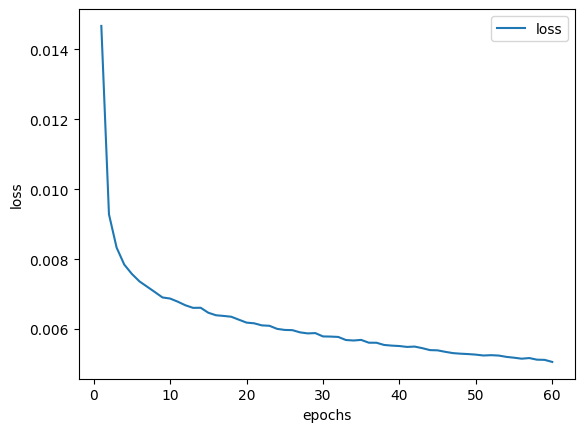

In [13]:
plt.plot(range(1, epochs+1), loss_history, label='loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

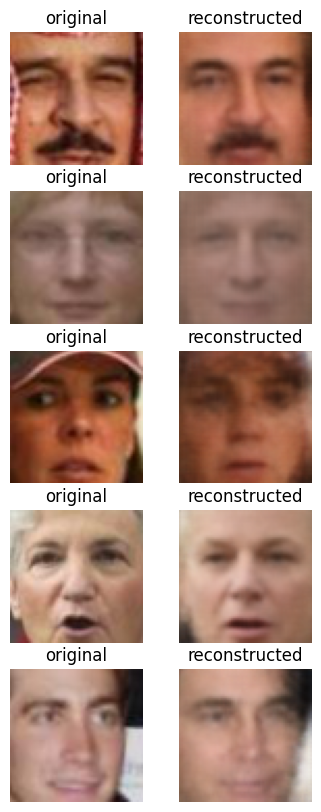

In [14]:
num_images = 5

autoencoder.eval()
plt.figure(figsize=(4, 2 * num_images))
for image_id in range(num_images):
    rand_img_id = np.random.randint(0, len(val_dataloader.dataset))
    img = torch.from_numpy(val_dataloader.dataset[rand_img_id])
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        reconstructed, _ = autoencoder(img)

    img = img.squeeze(0).cpu()
    reconstructed = reconstructed.squeeze(0).cpu()

    # plot original image and reconstructed
    plt.subplot(num_images, 2, (image_id * 2) + 1)
    plt.axis('off')
    plt.title('original')
    plt.imshow(img.permute(1, 2, 0))

    plt.subplot(num_images, 2, (image_id * 2 + 1) + 1)
    plt.axis('off')
    plt.title('reconstructed')
    plt.imshow(reconstructed.permute(1, 2, 0))

plt.show()

Not bad, right?

Good enough if we had bigger latent size, we would get better reconstructed images but we also might overfit the latent space

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [15]:
autoencoder.eval()
latent_code_vec = torch.FloatTensor()
for X_batch in train_dataloader:
    X_batch = X_batch.to(device)
    with torch.no_grad():
        _, latent_code = autoencoder(X_batch)
    latent_code_vec = torch.cat([latent_code_vec, latent_code.cpu()], dim=0)

In [16]:
mu = latent_code_vec.mean(dim=0)
sigma = latent_code_vec.std(dim=0)

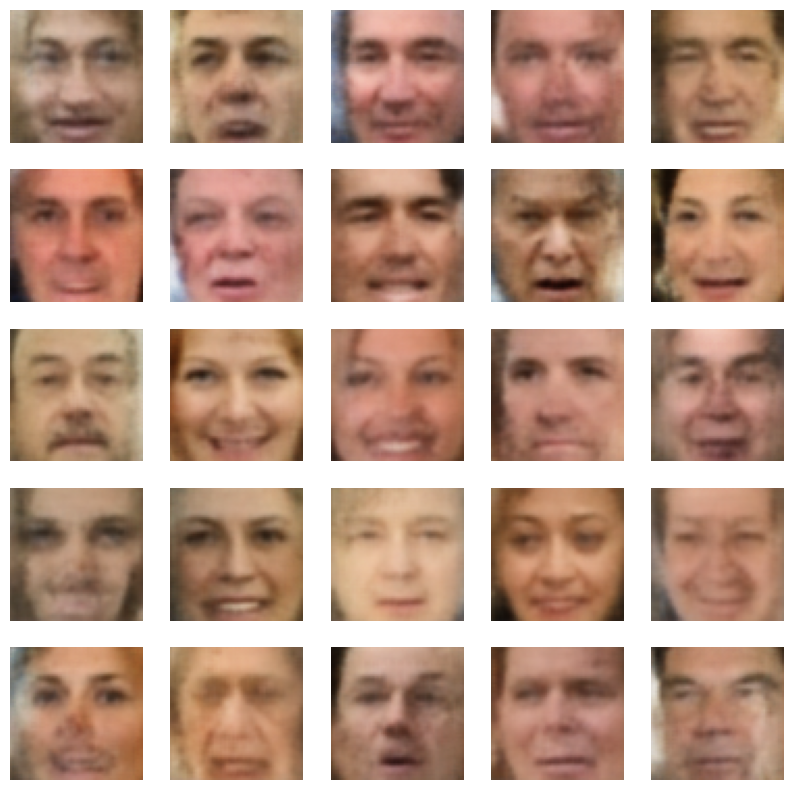

In [17]:
# сгенерируем 25 рандомных векторов размера latent_space
num_images = 25
autoencoder.eval()
input = torch.randn(num_images, latent_size)
input = (sigma * input + mu).to(device)
with torch.no_grad():
    output = autoencoder.decode(input)

plt.figure(figsize=(10, 10))
for image_id in range(num_images):
    img = output[image_id].permute(1, 2, 0).cpu()

    plt.subplot(5, 5, image_id + 1)
    plt.axis('off')
    plt.imshow(img)

plt.show()

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [18]:
split = 0.5

smile_ind = list(attrs[attrs['Smiling'] >= split].index)
not_smile_ind = list(attrs[attrs['Smiling'] <= -split].index)

In [19]:
smile_data = data[smile_ind]
not_smile_data = data[not_smile_ind]

In [20]:
smile_data.shape, not_smile_data.shape

((3996, 64, 64, 3), (5855, 64, 64, 3))

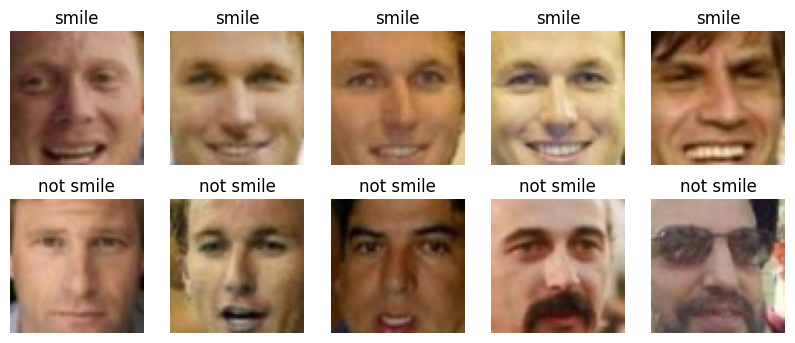

In [21]:
num_images = 5
plt.figure(figsize=(2 * num_images, 4))
for image_id in range(num_images):
    plt.subplot(2, num_images, image_id + 1)
    plt.title('smile')
    plt.axis('off')
    plt.imshow(smile_data[image_id])

    plt.subplot(2, num_images, num_images + image_id + 1)
    plt.title('not smile')
    plt.axis('off')
    plt.imshow(not_smile_data[image_id])
plt.show()

In [22]:
smile_latent_vec = torch.FloatTensor()
not_smile_latent_vec = torch.FloatTensor()

autoencoder.eval()
# let's get smile latent vectors
for image_id in range(len(smile_data)):
    img = torch.from_numpy(smile_data[image_id].astype(np.float32))
    img = img.permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        _, latent_code = autoencoder(img)
    smile_latent_vec = torch.cat([smile_latent_vec, latent_code.cpu()], dim=0)

# let's get not smile latent vectors
for image_id in range(len(not_smile_data)):
    img = torch.from_numpy(not_smile_data[image_id].astype(np.float32))
    img = img.permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        _, latent_code = autoencoder(img)
    not_smile_latent_vec = torch.cat([not_smile_latent_vec, latent_code.cpu()], dim=0)

In [23]:
smile_latent_vec = smile_latent_vec.mean(dim=0)
not_smile_latent_vec = not_smile_latent_vec.mean(dim=0)

In [24]:
smile_vec = (smile_latent_vec - not_smile_latent_vec).to(device)

In [25]:
smile_vec

tensor([  7.9064, -15.0848,  23.0153,  -9.4748, -16.0119,  18.4143,  38.3474,
         16.9313,   3.4350, -18.5195,  25.8819,  12.4602,   2.9588,   8.3854,
         29.2626,   4.4868, -24.1490, -17.1158, -27.7765,  -9.0233,  51.0899,
         -4.4410,  -0.2927,  42.1816,  12.2974,  13.1281,  21.9939,  -7.8463,
         -8.6323,  27.6350,   3.4787,   6.6790,  44.8431, -43.5133,  -1.0734,
          8.1853,  25.0584, -21.9170,   1.2405,   0.7137,  33.5017,   4.4628,
          2.4085,  -8.0835,  12.6888,   8.2666,   0.2199,  55.7475,  -2.7680,
         22.6334,  -6.9869, -22.6086,   7.2051, -12.2546, -23.2044,   0.6245,
         36.3881,  -3.9902, -25.2401,  13.4493, -15.2805,  38.4713,  16.0976,
        -12.8530], device='cuda:0')

### Let's make happy everyone

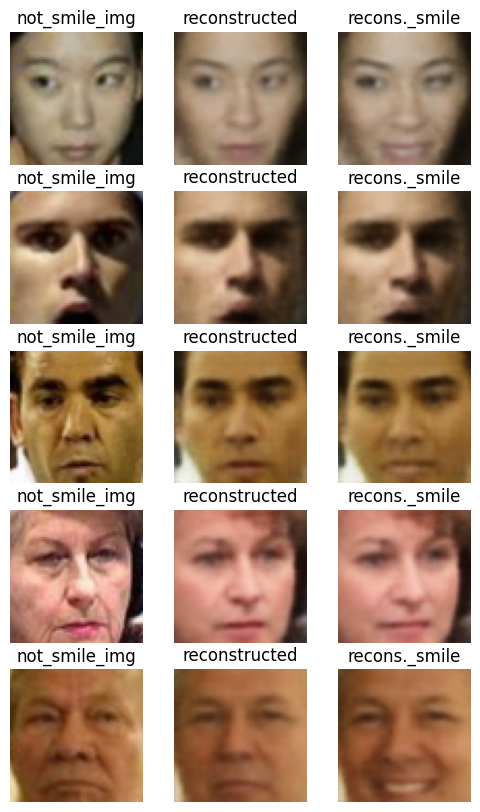

In [26]:
num_images = 5
autoencoder.eval()
plt.figure(figsize=(6, 2 * num_images))
for image_id in range(num_images):
    rand_img = np.random.randint(0, len(not_smile_data))
    not_smile_img = torch.from_numpy(not_smile_data[rand_img].astype(np.float32))
    not_smile_img = not_smile_img.permute(2, 0, 1).unsqueeze(0).to(device)

    with torch.no_grad():
        reconstructed, latent_code = autoencoder(not_smile_img)
        latent_code += smile_vec

        reconstructed_smile = autoencoder.decode(latent_code)

    # permute all of the to show
    not_smile_img = not_smile_img.squeeze(0).permute(1, 2, 0).cpu()
    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).cpu()
    reconstructed_smile = reconstructed_smile.squeeze(0).permute(1, 2, 0).cpu()

    plt.subplot(num_images, 3, 3 * image_id + 1)
    plt.axis('off')
    plt.title('not_smile_img')
    plt.imshow(not_smile_img)

    plt.subplot(num_images, 3, 3 * image_id + 2)
    plt.axis('off')
    plt.title('reconstructed')
    plt.imshow(reconstructed)

    plt.subplot(num_images, 3, 3 * image_id + 3)
    plt.axis('off')
    plt.title('recons._smile')
    plt.imshow(reconstructed_smile)


Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [27]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [28]:
class VAE(nn.Module):
    def __init__(self, in_channels, latent_size):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # (_, 64, 28, 28) -> (_, 64, 14, 14)
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # (_, 128, 14, 14) -> (_, 128, 7, 7)
            nn.MaxPool2d(kernel_size=2, stride=2),

            # (_, 128, 7, 7)(_, 128 * 7 * 7)
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
        )

        self.fc_mu = nn.Linear(1024, latent_size)
        self.fc_sigma = nn.Linear(1024, latent_size)

        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 128 * 7 * 7),
            # (_, 128 * 7 * 7) -> (_, 128, 7, 7)
            nn.Unflatten(1, (128, 7, 7)),
            # (_, 128, 7, 7) -> (_, 64, 14, 14)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # (_, 64, 32, 32) -> (_, 32, 64, 64)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, in_channels, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logsigma = self.fc_sigma(x)
        return mu, logsigma


    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            eps = torch.randn_like(logsigma)
            std = torch.exp(0.5 * logsigma)
            sample = std * eps + mu
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        reconstruction = self.decoder(z)
        return reconstruction


    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x)
        reconstruction = self.decode(self.gaussian_sampler(mu, logsigma))
        return mu, logsigma, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [29]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    return -(1 + logsigma - mu ** 2 - logsigma.exp()).sum() * 0.5

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction, beta=1):
    return log_likelihood(x, reconstruction) + beta * KL_divergence(mu, logsigma)


И обучим модель:

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
epochs = 60
latent_size = 64

criterion = loss_vae
autoencoder = VAE(in_channels=1, latent_size=latent_size).to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=3e-4)

In [32]:
autoencoder.train()
loss_history = []
for epoch in range(epochs):
    running_loss = 0
    total_data = 0

    for X_batch, _ in train_loader:
        X_batch = X_batch.to(device)
        optimizer.zero_grad()

        mu, logsigma, reconstruction = autoencoder(X_batch)
        loss = criterion(X_batch, mu, logsigma, reconstruction)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        total_data += X_batch.size(0)

    loss = running_loss / total_data
    loss_history.append(loss)

    print(f"Epoch: {epoch+1}/{epochs}, loss: {loss}")

Epoch: 1/60, loss: 6473.356134635416
Epoch: 2/60, loss: 6180.8998265625
Epoch: 3/60, loss: 6018.838056770834
Epoch: 4/60, loss: 5949.814071614584
Epoch: 5/60, loss: 5898.704352083333
Epoch: 6/60, loss: 5861.19879375
Epoch: 7/60, loss: 5820.085181510417
Epoch: 8/60, loss: 5799.58415859375
Epoch: 9/60, loss: 5761.671567708333
Epoch: 10/60, loss: 5709.24068203125
Epoch: 11/60, loss: 5654.134066927083
Epoch: 12/60, loss: 5633.0576463541665
Epoch: 13/60, loss: 5579.054218489583
Epoch: 14/60, loss: 5506.8806283854165
Epoch: 15/60, loss: 5470.230315625
Epoch: 16/60, loss: 5414.75
Epoch: 17/60, loss: 5346.477514583334
Epoch: 18/60, loss: 5303.677180208333
Epoch: 19/60, loss: 5270.551754947916
Epoch: 20/60, loss: 5230.7283815104165
Epoch: 21/60, loss: 5190.1140515625
Epoch: 22/60, loss: 5150.369894270833
Epoch: 23/60, loss: 5115.413596614583
Epoch: 24/60, loss: 5079.951070182292
Epoch: 25/60, loss: 5040.256612239584
Epoch: 26/60, loss: 5016.703104166667
Epoch: 27/60, loss: 4986.913251302083
Epo

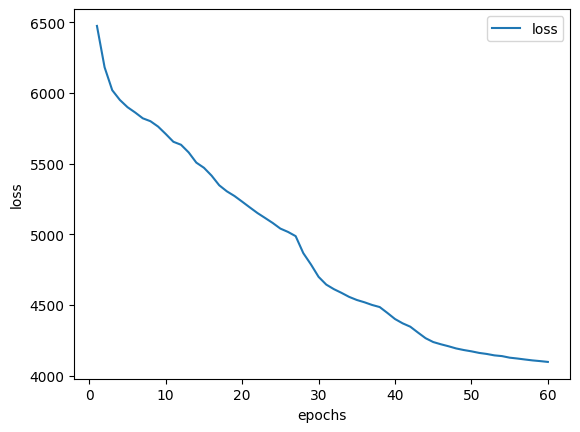

In [33]:
plt.plot(range(1, epochs+1), loss_history, label='loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

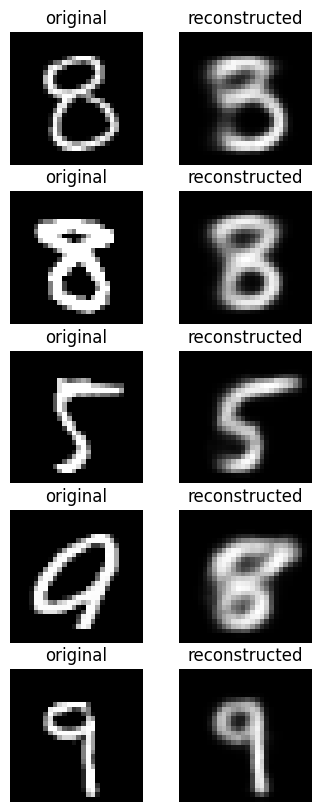

In [34]:
num_images = 5

autoencoder.eval()
num_images_test = len(test_dataset)
plt.figure(figsize=(4, 2 * num_images))
for image_id in range(num_images):
    rand_img_id = np.random.randint(0, num_images_test)
    img = test_dataset[rand_img_id][0]
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        _, _, reconstructed = autoencoder(img)

    img = img.squeeze(0).cpu()
    reconstructed = reconstructed.squeeze(0).cpu()

    # plot original image and reconstructed
    plt.subplot(num_images, 2, (image_id * 2) + 1)
    plt.axis('off')
    plt.title('original')
    plt.imshow(img.permute(1, 2, 0), cmap='gray')

    plt.subplot(num_images, 2, (image_id * 2 + 1) + 1)
    plt.axis('off')
    plt.title('reconstructed')
    plt.imshow(reconstructed.permute(1, 2, 0), cmap='gray')

plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

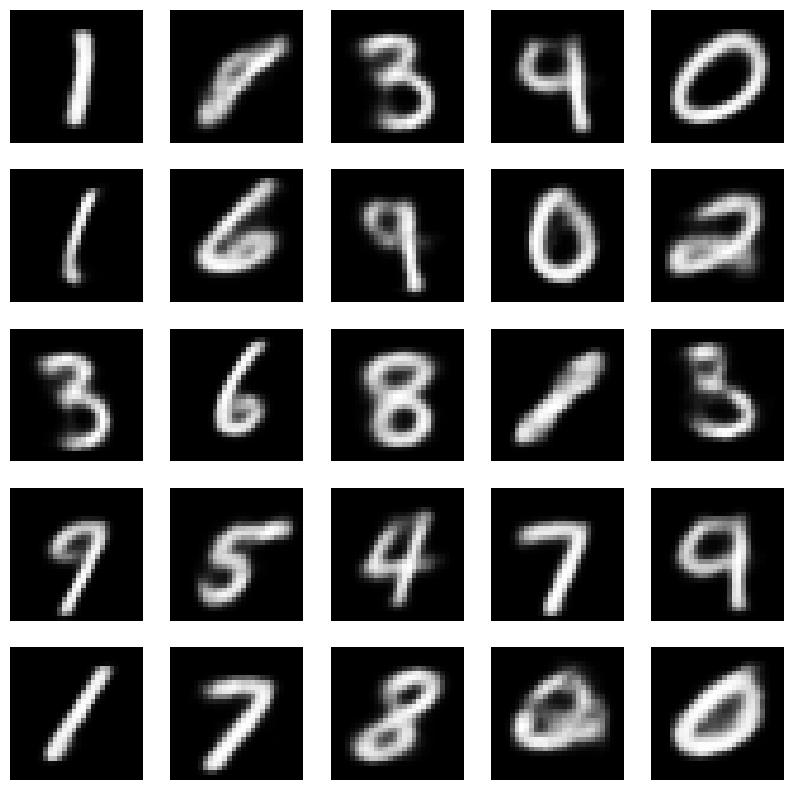

In [35]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
num_images = 25
input = torch.randn(num_images, latent_size).to(device)
with torch.no_grad():
    output = autoencoder.decode(input)

plt.figure(figsize=(10, 10))
for image_id in range(num_images):
    img = output[image_id].permute(1, 2, 0).cpu()

    plt.subplot(5, 5, image_id + 1)
    plt.axis('off')
    plt.imshow(img, cmap='gray')

plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [36]:
autoencoder.eval()
latent_vec = torch.FloatTensor()
label_vec = torch.FloatTensor()
with torch.no_grad():
    for (X_batch, y_batch) in test_loader:
        X_batch = X_batch.to(device)
        mu, _, = autoencoder.encode(X_batch)
        latent_vec = torch.cat([latent_vec, mu.cpu()], dim=0)
        label_vec = torch.cat([label_vec, y_batch], dim=0)

In [37]:
from sklearn.manifold import TSNE
transform_tensors = TSNE(n_components=2).fit_transform(latent_vec)

Text(0.5, 1.0, 'TSNE distribution of the Numbers')

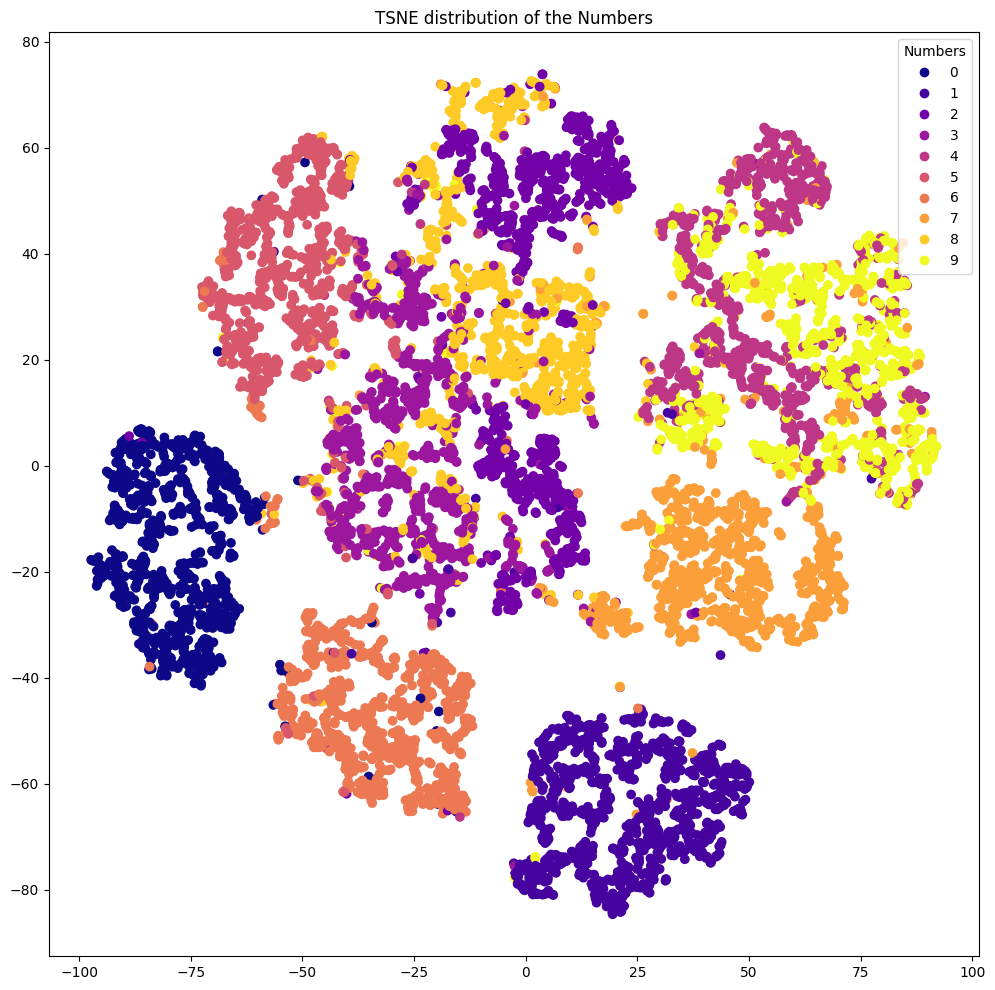

In [38]:
fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(
    transform_tensors[:, 0],
    transform_tensors[:, 1],
    c=label_vec.long(),
    label=label_vec.long(),
    cmap='plasma'
)
ax.legend(*scatter.legend_elements(), loc="upper right", title="Numbers")
plt.title('TSNE distribution of the Numbers')

Что вы думаете o виде латентного представления?

VAE did a good job, it easy to see that VAE was able to correctly configure latent space

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [39]:
class CVAE(nn.Module):
    def __init__(self, in_channels, latent_size, num_classes):
        super(CVAE, self).__init__()

        self.num_classes = num_classes
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # (_, 64, 28, 28) -> (_, 64, 14, 14)
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # (_, 128, 14, 14) -> (_, 128, 7, 7)
            nn.MaxPool2d(kernel_size=2, stride=2),

            # (_, 128, 7, 7)(_, 128 * 7 * 7)
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
        )

        self.fc_mu = nn.Linear(1024, latent_size)
        self.fc_sigma = nn.Linear(1024, latent_size)

        self.decoder = nn.Sequential(
            nn.Linear(latent_size + num_classes, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 128 * 7 * 7),
            # (_, 128 * 7 * 7) -> (_, 128, 7, 7)
            nn.Unflatten(1, (128, 7, 7)),
            # (_, 128, 7, 7) -> (_, 64, 14, 14)
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # (_, 64, 32, 32) -> (_, 32, 64, 64)
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, in_channels, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )


    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        sigma = self.fc_sigma(x)
        return mu, sigma


    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            eps = torch.randn_like(logsigma)
            std = torch.exp(0.5 * logsigma)
            sample = std * eps + mu
            return sample
        else:
            return mu


    def decode(self, latent_code, class_num=None):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        if class_num is not None:
            one_hot_class = F.one_hot(class_num, self.num_classes).to(device, dtype=torch.float32)
            latent_code = torch.cat([latent_code, one_hot_class], dim=1)

        reconstruction = self.decoder(latent_code)
        return reconstruction


    def forward(self, x, labels):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, sigma = self.encode(x)
        latent_code = self.gaussian_sampler(mu, sigma)
        reconstruction = self.decode(latent_code, labels)
        return mu, sigma, reconstruction

In [40]:
epochs = 60
latent_size = 64

criterion = loss_vae
autoencoder = CVAE(in_channels=1, latent_size=latent_size, num_classes=10).to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=3e-4)

In [41]:
loss_history = []
autoencoder.train()
for epoch in range(epochs):
    running_loss = 0
    total_data = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()

        mu, logsigma, reconstruction = autoencoder(X_batch, y_batch)
        loss = criterion(X_batch, mu, logsigma, reconstruction)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        total_data += X_batch.size(0)

    loss = running_loss / total_data
    loss_history.append(loss)
    print(f"Epoch: {epoch+1}/{epochs}, loss: {loss}")

Epoch: 1/60, loss: 5623.2035653645835
Epoch: 2/60, loss: 5062.337614322917
Epoch: 3/60, loss: 4925.468141666666
Epoch: 4/60, loss: 4871.9101546875
Epoch: 5/60, loss: 4838.216989713542
Epoch: 6/60, loss: 4814.289588671875
Epoch: 7/60, loss: 4790.4316649739585
Epoch: 8/60, loss: 4772.338347786458
Epoch: 9/60, loss: 4755.662339713542
Epoch: 10/60, loss: 4739.405484375
Epoch: 11/60, loss: 4708.357718619792
Epoch: 12/60, loss: 4689.694719270833
Epoch: 13/60, loss: 4655.428612760416
Epoch: 14/60, loss: 4641.845215234375
Epoch: 15/60, loss: 4621.082491015625
Epoch: 16/60, loss: 4608.151304427083
Epoch: 17/60, loss: 4602.439860416666
Epoch: 18/60, loss: 4589.2911796875
Epoch: 19/60, loss: 4586.533121354167
Epoch: 20/60, loss: 4567.346349609375
Epoch: 21/60, loss: 4537.51105859375
Epoch: 22/60, loss: 4523.117971744791
Epoch: 23/60, loss: 4504.30813359375
Epoch: 24/60, loss: 4477.725705078125
Epoch: 25/60, loss: 4465.887986588542
Epoch: 26/60, loss: 4453.115541666667
Epoch: 27/60, loss: 4447.749

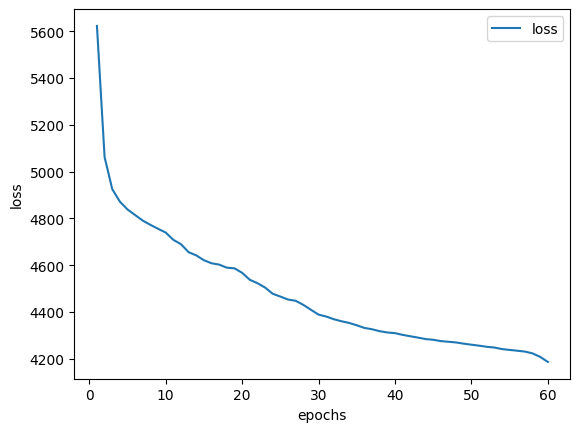

In [42]:
plt.plot(range(1, epochs+1), loss_history, label='loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

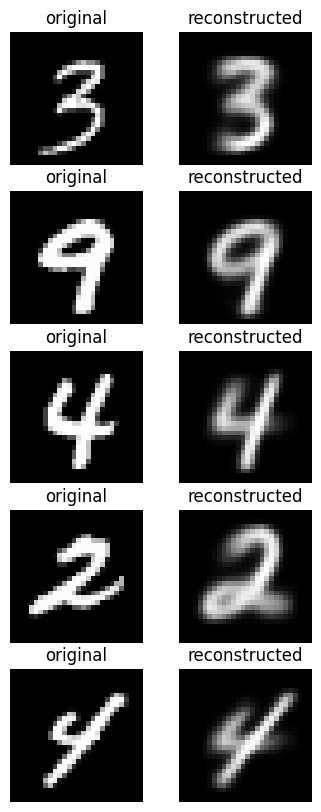

In [43]:
num_images = 5

autoencoder.eval()
num_images_test = len(test_dataset)
plt.figure(figsize=(4, 2 * num_images))
for image_id in range(num_images):
    rand_img_id = np.random.randint(0, num_images_test)
    img = test_dataset[rand_img_id][0]
    label = torch.from_numpy(np.array([test_dataset[rand_img_id][1]])).to(device)
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        _, _, reconstructed = autoencoder(img, label)

    img = img.squeeze(0).cpu()
    reconstructed = reconstructed.squeeze(0).cpu()

    # plot original image and reconstructed
    plt.subplot(num_images, 2, (image_id * 2) + 1)
    plt.axis('off')
    plt.title('original')
    plt.imshow(img.permute(1, 2, 0), cmap='gray')

    plt.subplot(num_images, 2, (image_id * 2 + 1) + 1)
    plt.axis('off')
    plt.title('reconstructed')
    plt.imshow(reconstructed.permute(1, 2, 0), cmap='gray')

plt.show()

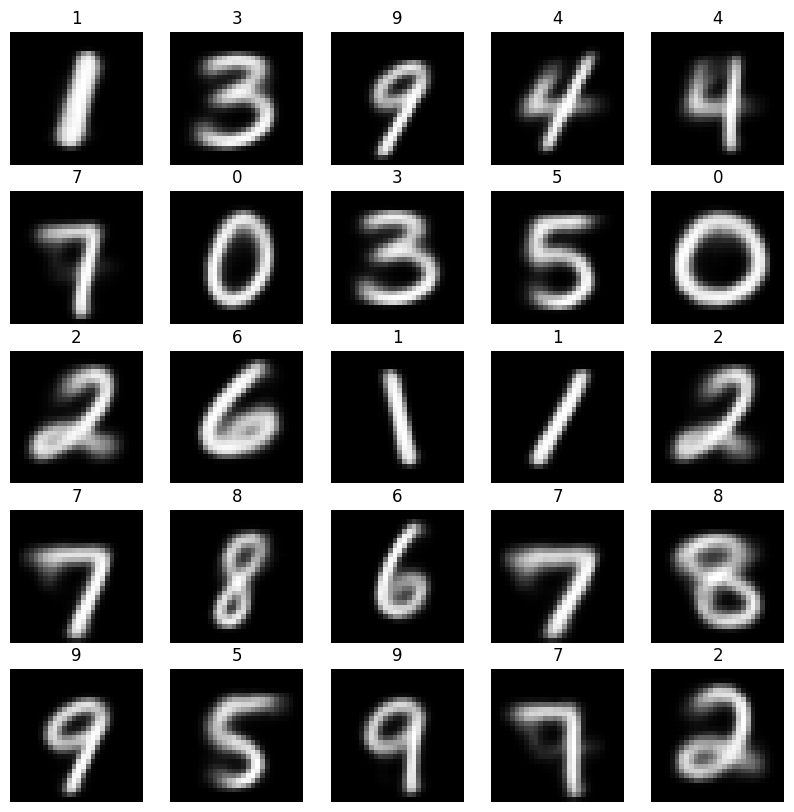

In [44]:
# Let's generate new images according to given label

num_images = 25
input = torch.randn(num_images, latent_size).to(device)
labels = torch.from_numpy(np.random.randint(0, 10, size=num_images)).to(device)
with torch.no_grad():
    output = autoencoder.decode(input, labels)

plt.figure(figsize=(10, 10))
for image_id in range(num_images):
    img = output[image_id].permute(1, 2, 0).cpu()
    label = labels[image_id].cpu()

    plt.subplot(5, 5, image_id + 1)
    plt.axis('off')
    plt.title(label.item())
    plt.imshow(img, cmap='gray')

plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [45]:
autoencoder.eval()
latent_vec = torch.FloatTensor()
label_vec = torch.FloatTensor()
with torch.no_grad():
    for (X_batch, y_batch) in test_loader:
        X_batch = X_batch.to(device)
        mu, _, = autoencoder.encode(X_batch)
        latent_vec = torch.cat([latent_vec, mu.cpu()], dim=0)
        label_vec = torch.cat([label_vec, y_batch], dim=0)

Text(0.5, 1.0, 'TSNE distribution of the Numbers')

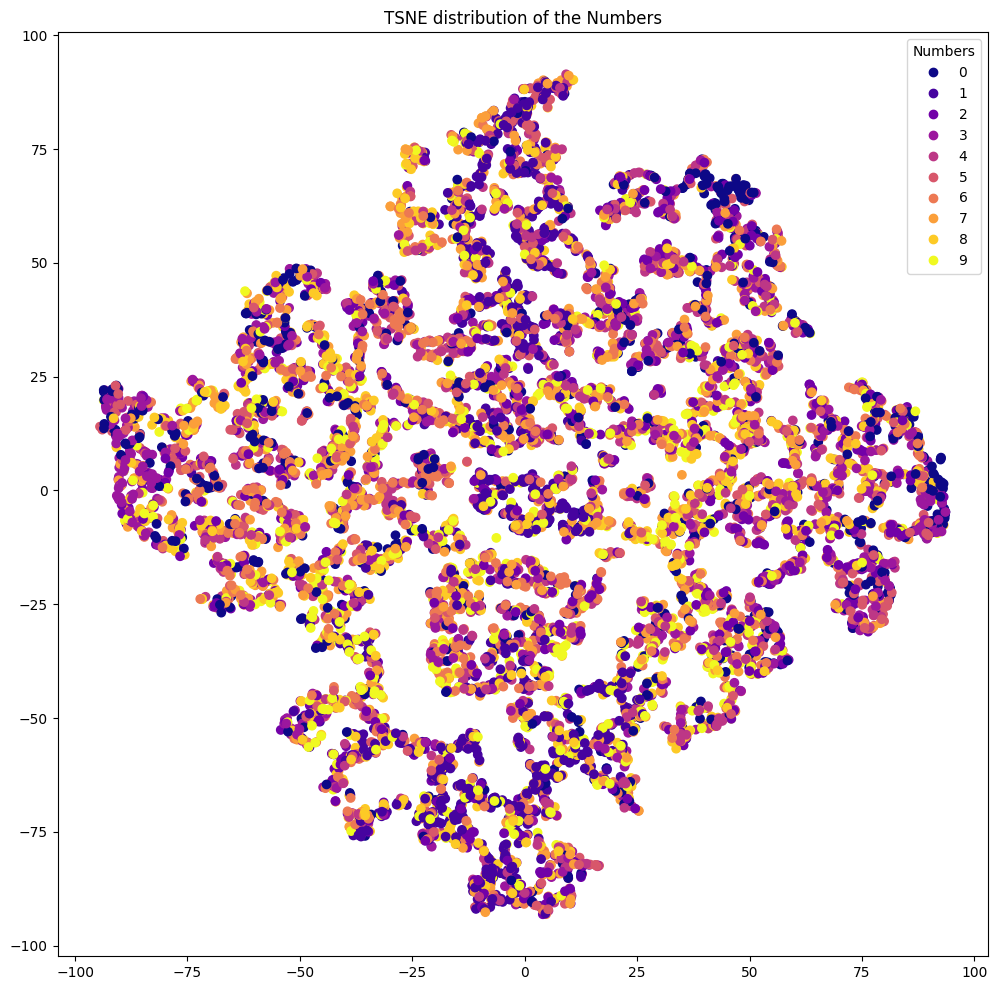

In [46]:
from sklearn.manifold import TSNE
transform_tensors = TSNE(n_components=2).fit_transform(latent_vec)

fig, ax = plt.subplots(figsize=(12, 12))
scatter = ax.scatter(
    transform_tensors[:, 0],
    transform_tensors[:, 1],
    c=label_vec.long(),
    label=label_vec.long(),
    cmap='plasma'
)
ax.legend(*scatter.legend_elements(), loc="upper right", title="Numbers")
plt.title('TSNE distribution of the Numbers')

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

Now our Encoder relies on given labels, that why latent space is looking so ugly

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [47]:
# noise_factor = 0.5
# X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [48]:
def add_noise(img, mean=0, std=1, factor=0.5):
    return img + factor * torch.randn(img.size()) * std + mean

In [49]:
epochs = 60
latent_size = 64

criterion = nn.MSELoss()
autoencoder = Autoencoder(in_channels=3, latent_size=latent_size).to(device)
optimizer = torch.optim.AdamW(autoencoder.parameters(), lr=3e-4)

In [50]:
autoencoder.train()
loss_history = []
for epoch in range(epochs):
    running_loss = 0
    total_data = 0

    for X_batch in train_dataloader:
        X_batch_noise = add_noise(X_batch).to(device)
        X_batch = X_batch.to(device)
        optimizer.zero_grad()

        reconstruction, _ = autoencoder(X_batch_noise)
        loss = criterion(reconstruction, X_batch)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X_batch.size(0)
        total_data += X_batch.size(0)

    loss = running_loss / total_data
    loss_history.append(loss)

    print(f"Epoch: {epoch+1}/{epochs}, loss: {loss}")

Epoch: 1/60, loss: 0.016015097388169634
Epoch: 2/60, loss: 0.010596835438359797
Epoch: 3/60, loss: 0.009256035134491074
Epoch: 4/60, loss: 0.008812390692675207
Epoch: 5/60, loss: 0.00845665423724278
Epoch: 6/60, loss: 0.008237424469114466
Epoch: 7/60, loss: 0.00803808436780567
Epoch: 8/60, loss: 0.007967516171537086
Epoch: 9/60, loss: 0.007845489168991398
Epoch: 10/60, loss: 0.007769131287064319
Epoch: 11/60, loss: 0.007632247312959948
Epoch: 12/60, loss: 0.0075767610555336476
Epoch: 13/60, loss: 0.007518932550354717
Epoch: 14/60, loss: 0.007498035443100255
Epoch: 15/60, loss: 0.007383250364236886
Epoch: 16/60, loss: 0.0073615460301734706
Epoch: 17/60, loss: 0.007301722935778074
Epoch: 18/60, loss: 0.007295397235711639
Epoch: 19/60, loss: 0.007190336968090023
Epoch: 20/60, loss: 0.007167889207685875
Epoch: 21/60, loss: 0.007123655950147797
Epoch: 22/60, loss: 0.0071049028417970355
Epoch: 23/60, loss: 0.007044870741573241
Epoch: 24/60, loss: 0.007024942927111407
Epoch: 25/60, loss: 0.00

In [ ]:
plt.plot(range(1, epochs+1), loss_history, label='loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## Let's see how our AutoEncoder removes noisy from the image

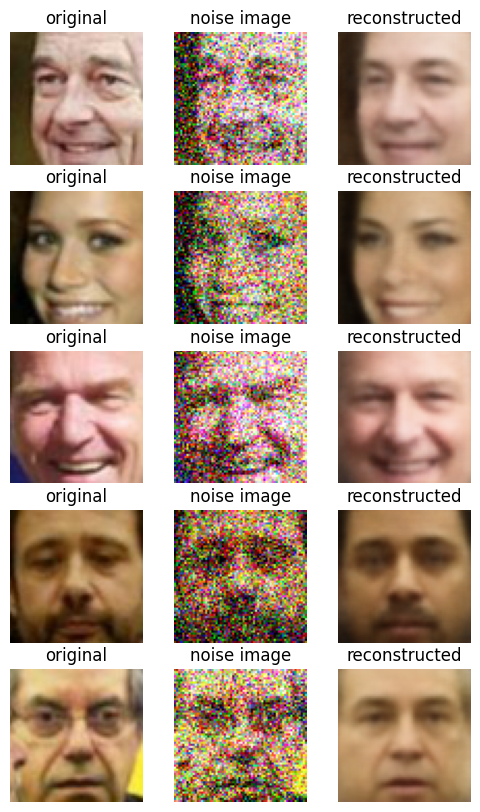

In [52]:
num_images = 5

autoencoder.eval()
test_dataset = val_dataloader.dataset
num_images_test = len(test_dataset)
plt.figure(figsize=(6, 2 * num_images))
for image_id in range(num_images):
    rand_img_id = np.random.randint(0, num_images_test)
    img = torch.from_numpy(test_dataset[rand_img_id])
    img_noise = add_noise(img, factor=0.3)
    img_noise = img_noise.unsqueeze(0).to(device)

    with torch.no_grad():
        reconstructed, _ = autoencoder(img_noise)

    img_noise = img_noise.squeeze(0).cpu()
    reconstructed = reconstructed.squeeze(0).cpu()

    # plot original image and reconstructed
    plt.subplot(num_images, 3, (image_id * 3) + 1)
    plt.axis('off')
    plt.title('original')
    plt.imshow(img.permute(1, 2, 0), cmap='gray')

    plt.subplot(num_images, 3, (image_id * 3 + 1) + 1)
    plt.axis('off')
    plt.title('noise image')
    plt.imshow(img_noise.permute(1, 2, 0).clip(0, 1), cmap='gray')

    plt.subplot(num_images, 3, (image_id * 3 + 2) + 1)
    plt.axis('off')
    plt.title('reconstructed')
    plt.imshow(reconstructed.permute(1, 2, 0), cmap='gray')

plt.show()